<a href="https://colab.research.google.com/gist/jonghank/9cf13955ab3cbb3c844d1e5455b20fb6/sparse_solutions_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sparse solutions

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\argmin}{{\text{argmin}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\E}{\mathbf{E}}
\newcommand{\var}{\mathbf{var}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\B}{\mathbf{B}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> ASE7030: Convex Optimization, Inha University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@inha.ac.kr) </div>_


<br>

## Loss functions in different norms

<br>

Suppose you are given a vector $y\in\R^{10}$, where all the elements are $1$'s except for the last element which is $2$. 0

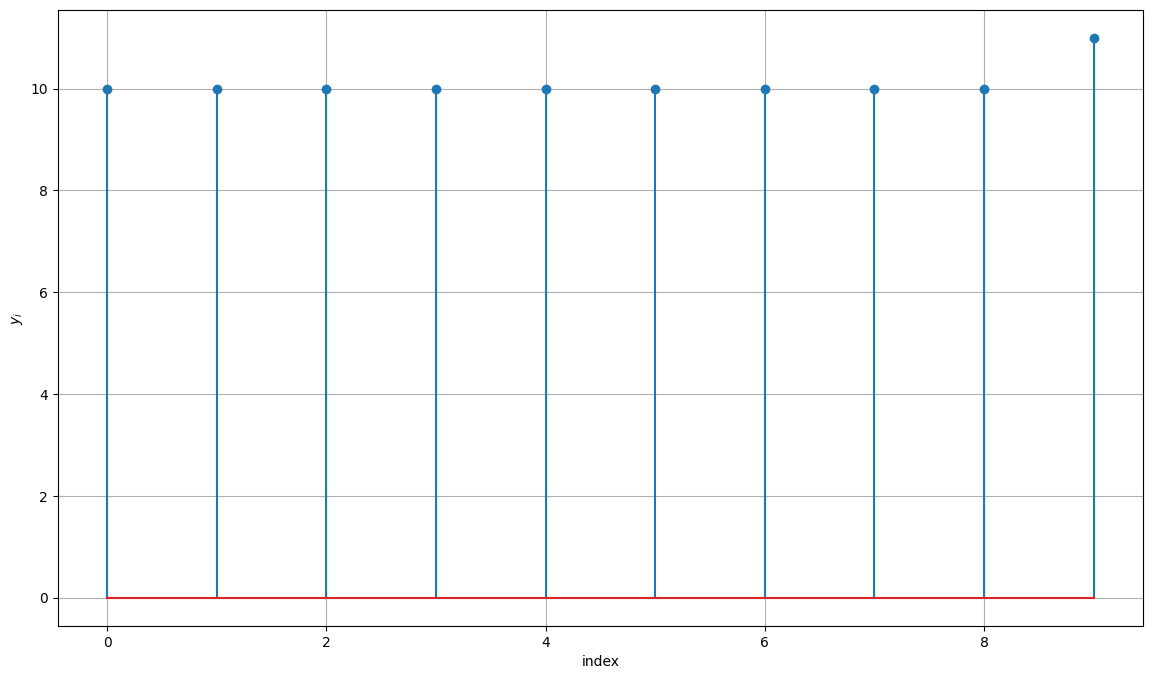

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

n = 10
onev = np.ones(n)
y = 10*onev
y[-1] = 11

plt.figure(figsize=(14,8), dpi=100)
#plt.stem(y, use_line_collection=True)
plt.stem(y)
plt.xlabel('index')
plt.ylabel(r'$y_i$')
plt.grid()
plt.show()

<br>

A smart way to choose such $\hat{y}$ can be obtained via defining appropriate loss functions and solving an optimization problem minimizing the loss, such as,

$$
\underset{\hat{y}}{\minimize} \quad \sum_{i=1}^{10} | \hat{y}- y_i|^p
$$

for some $p\ge1$. This is equivalent to

$$
\underset{\hat{y}}{\minimize} \quad \| {\mathbf 1}\hat{y}- y \|_p
$$

The following finds the solutions by $p=1, 2, \infty$.

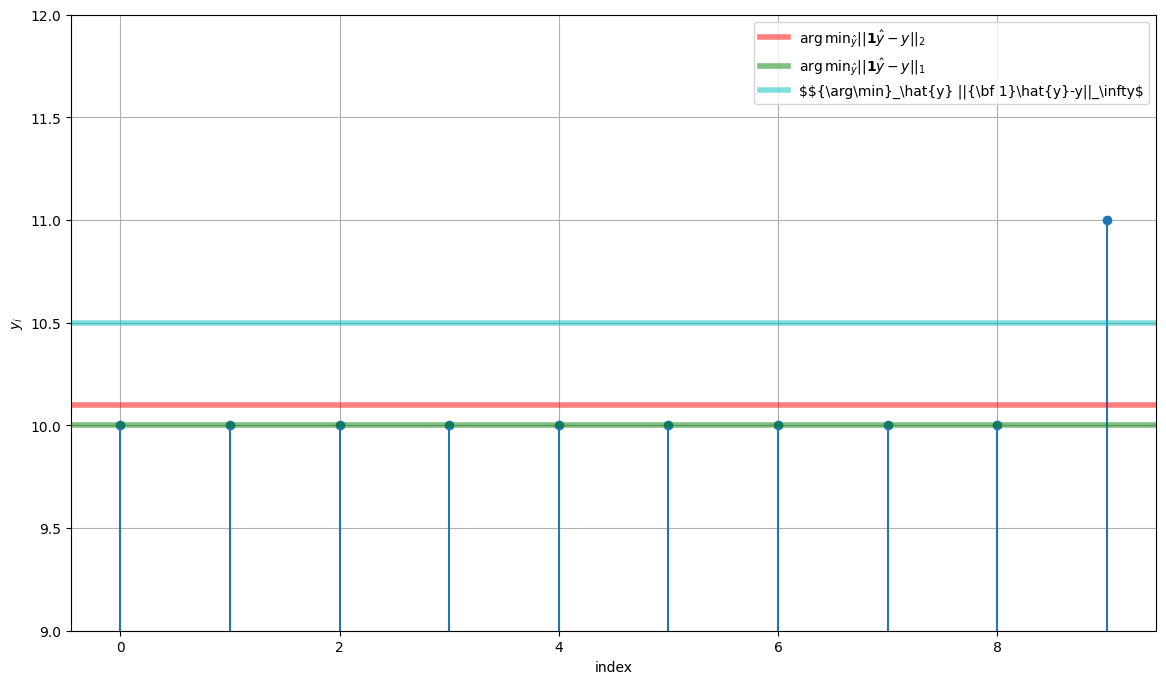

In [2]:
yhat = cp.Variable()

loss_2norm = cp.norm(yhat-y, 2)
loss_1norm = cp.norm(yhat-y, 1)
loss_infty = cp.norm(yhat-y, 'inf')

obj = cp.Minimize(loss_2norm)
prob = cp.Problem(obj)
prob.solve()
yhat_2norm = yhat.value

obj = cp.Minimize(loss_1norm)
prob = cp.Problem(obj)
prob.solve()
yhat_1norm = yhat.value

obj = cp.Minimize(loss_infty)
prob = cp.Problem(obj)
prob.solve()
yhat_infty = yhat.value

plt.figure(figsize=(14,8), dpi=100)
plt.stem(y)
plt.axhline(yhat_2norm, color='r', alpha=0.5, linewidth=4, \
            label=r'${\arg\min}_\hat{y} ||{\bf 1}\hat{y}-y||_2$')
plt.axhline(yhat_1norm, color='g', alpha=0.5, linewidth=4, \
            label=r'${\arg\min}_\hat{y} ||{\bf 1}\hat{y}-y||_1$')
plt.axhline(yhat_infty, color='c', alpha=0.5, linewidth=4, \
            label=r'$${\arg\min}_\hat{y} ||{\bf 1}\hat{y}-y||_\infty$')
plt.grid(), plt.legend()
plt.xlabel('index')
plt.ylabel(r'$y_i$')
plt.ylim(9,12) 
plt.show()


What do you observe?

<br>

## Underdetermined system of linear equations

<br>

You are given with a system of linear equations, $y=Ax$, where $y\in\R^m$ represents the measurement vector (which is available to you), $x\in\R^n$ is the unknown (which your want to reconstruct from $y$), $A\in\R^{m\times n}$ is  the known measurement matrix which maps $x\in\R^n$ to $y\in\R^m$. In other words, your are given with $y$ and $A$, and job is to reconstruct $x$ from them.

This problem is solvable when $m=n$ (and $A$ is full rank), or if $m>n$ you can handle a little more complicated situations when $y$ are corrupted by noise. This implies that _you should have more measurements than unknowns_.

When $m<n$ (when you have fewer measurements than unknowns), you will not be able to exactly reconstruct the original signal $x$ in general.  One intuitive explanation is that the equation has infinitely many solutions, so you don't know which one to choose from them. However you will be able to do something smart when $x$ is _sparse_ in some domain. Note that being sparse does not reduce the problem size though, since you don't know where the nonzero elements are.

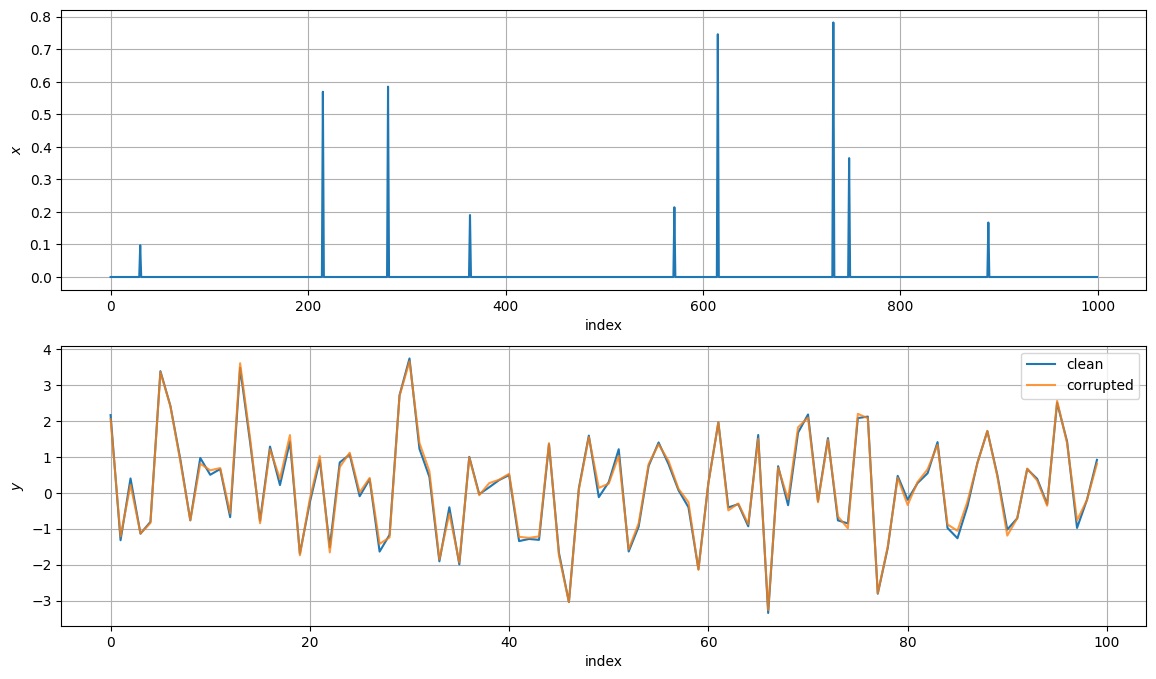

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

m = 100
n = 1000

np.random.seed(7030)
A = np.random.randn(m, n)
x = np.random.rand(n)
x *= np.random.rand(n)>0.99
y_clean = np.dot(A, x)
y = y_clean + 0.1*np.random.randn(m)

plt.figure(figsize=(14,8), dpi=100)
plt.subplot(211)
plt.plot(x)
plt.grid()
plt.xlabel('index'), plt.ylabel(r'$x$')
plt.subplot(212)
plt.plot(y_clean, label='clean')
plt.plot(y, alpha=0.8, label='corrupted')
plt.grid(), plt.legend()
plt.xlabel('index')
plt.ylabel(r'$y$')
plt.show()

<br>

First we will try the least norm solution.

\begin{align*}
\underset{x}{\minimize} &\quad \| x \|_2 \\
\text{subject to} &\quad Ax=y
\end{align*}


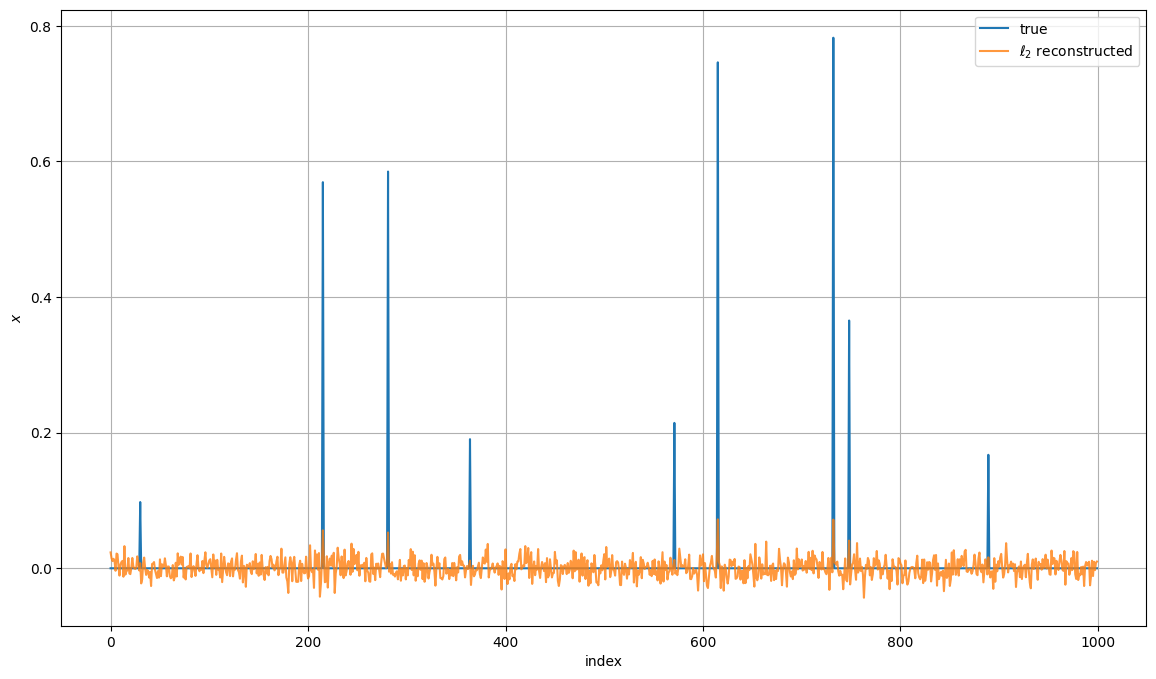

In [4]:
xhat = cp.Variable(n)

loss_2norm = cp.norm(xhat, 2)
obj = cp.Minimize(loss_2norm)
constr = [ A@xhat==y ]
prob = cp.Problem(obj, constr)
prob.solve()
xhat_2norm = xhat.value

plt.figure(figsize=(14,8), dpi=100)
plt.plot(x, label='true')
plt.plot(xhat_2norm, alpha=0.8, label=r'$\ell_2$ reconstructed')
plt.grid(), plt.legend()
plt.xlabel('index'), plt.ylabel(r'$x$')
plt.show()

Nothing interesting. The next is the $\ell_2$-regularized least squares, which is basically the same as the above:

\begin{align*}
\underset{x}{\minimize} &\quad \|Ax-y\|_2^2 + \lambda \| x \|_2 
\end{align*}


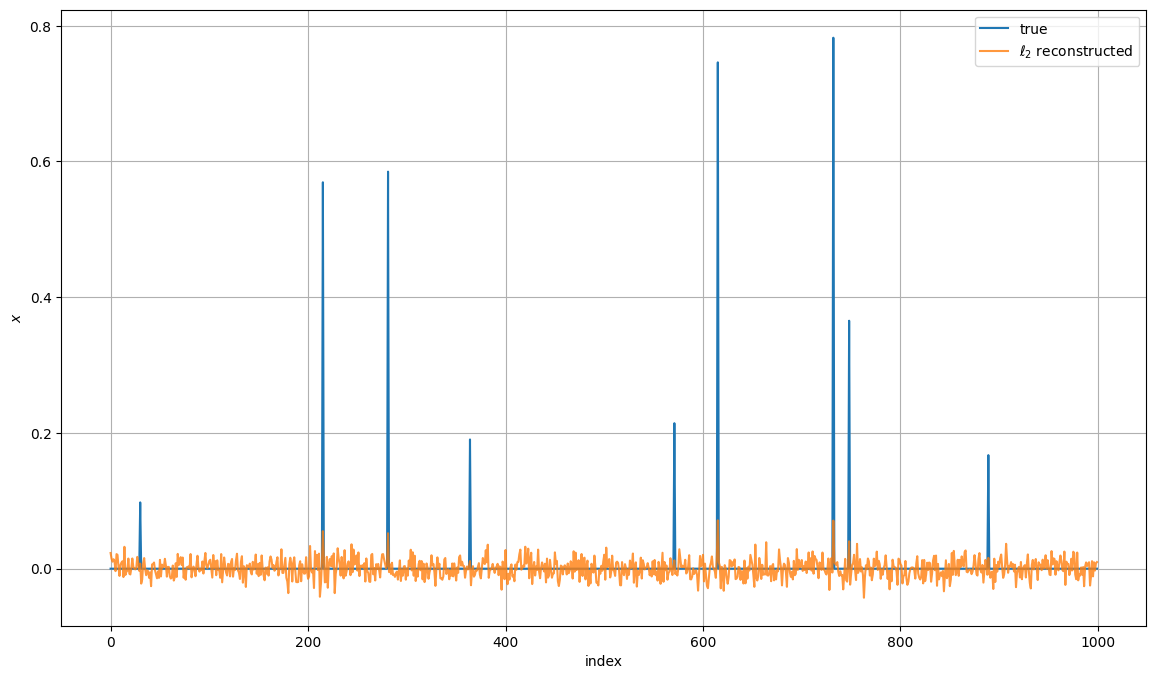

In [5]:
xhat = cp.Variable(n)

loss_2norm = cp.sum_squares(A@xhat-y) 
regu_2norm = cp.norm(xhat,2)
obj = cp.Minimize(loss_2norm + 10*regu_2norm)
prob = cp.Problem(obj)
prob.solve()
xhat_2norm = xhat.value

plt.figure(figsize=(14,8), dpi=100)
plt.plot(x, label='true')
plt.plot(xhat_2norm, alpha=0.8, label=r'$\ell_2$ reconstructed')
plt.grid(), plt.legend()
plt.xlabel('index'), plt.ylabel(r'$x$')
plt.show()

<br>

The $\ell_1$-regularized least squares:

\begin{align*}
\underset{x}{\minimize} &\quad \|Ax-y\|_2^2 + \lambda \| x \|_1 
\end{align*}

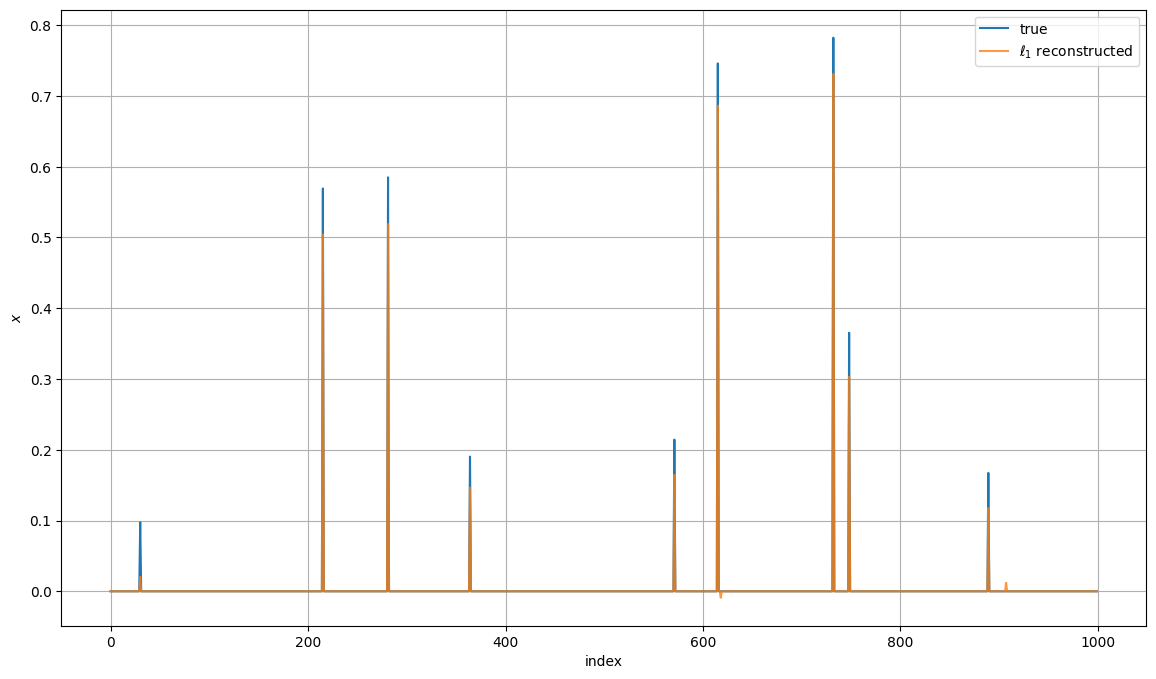

In [6]:
xhat = cp.Variable(n)

loss_2norm = cp.sum_squares(A@xhat-y) 
regu_1norm = cp.norm(xhat,1)
obj = cp.Minimize(loss_2norm + 10*regu_1norm)
prob = cp.Problem(obj)
prob.solve()
xhat_1norm = xhat.value

plt.figure(figsize=(14,8), dpi=100)
plt.plot(x, label='true')
plt.plot(xhat_1norm, alpha=0.8, label=r'$\ell_1$ reconstructed')
plt.grid(), plt.legend()
plt.xlabel('index'), plt.ylabel(r'$x$')
plt.show()